In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import sys
import platform
import sklearn
import statsmodels.api as sm
import seaborn as sns
sns.set(style="darkgrid") # set style

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
Python Version: 3.6.8


In [2]:
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
def analyze_preds_true(preds_y, true_y):
    """Code to analyze MSE, worst errors, plot residuals"""
    resids = preds_y - true_y
    print('Residual distribution:\n',stats.describe(resids))
    print('\nMSE:',mean_squared_error(true_y, preds_y))
    ## plot 1 is just pred vs true y
    sns.scatterplot(x=preds_y, y=true_y)
    plt.xlabel("Predictions")
    plt.ylabel("True")
    plt.title("Preds vs True")
    plt.show()
    ## plot 2 is redisuals
    sns.residplot(x=preds_y, y=resids,
                  lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residual Plots")
    plt.show()

In [4]:
## create two train and test files, 
def create_train_test(data, cols, test_year, y_col = 'log_count'):
    prev_year = test_year - 1
    X_train_all = data.query('year!=@test_year')[cols]
    y_train_all = data.query('year!=@test_year')[y_col]
    X_train_prevyear = data.query('year==@prev_year')[cols]
    y_train_prevyear = data.query('year==@prev_year')[y_col]
    
    X_test = data.query('year==@test_year')[cols]
    y_test = data.query('year==@test_year')[y_col]
    ## quick checks
    assert X_train_all.shape[0] == len(y_train_all) 
    assert X_train_prevyear.shape[0] == len(y_train_prevyear) 
    assert X_test.shape[0] == len(y_test) 
    assert X_train_all.shape[1] == len(cols) 
    print('There are %s training obs and %s test obs' % (len(y_train_all), len(y_test)))
    
    return(X_train_all, y_train_all, X_train_prevyear, y_train_prevyear, X_test, y_test)

In [5]:
def grid_search(model, param_search, scoring, X_train, Y_train, cv, refit='neg_mean_squared_error'):
    """Function for grid search and return best estimator
    Options:
    Regression
    ‘explained_variance’: metrics.explained_variance_score
    ‘neg_mean_absolute_error’: metrics.mean_absolute_error
    ‘neg_mean_squared_error’: metrics.mean_squared_error
    ‘neg_mean_squared_log_error’: metrics.mean_squared_log_error
    ‘neg_median_absolute_error’: metrics.median_absolute_error
    ‘r2’: metrics.r2_score

    """
    grid = GridSearchCV(estimator=model, cv=cv,
                        param_grid=param_search, scoring = scoring,
                        refit=refit, return_train_score=True, verbose=1) # metric b/c balanced data set

    gs = grid.fit(X_train, Y_train)
    best_model = gs.best_estimator_ # based on roc_auc score
    return(gs, best_model)

## Import Data

In [6]:
crime_data = pd.read_csv("../../data/data_include_all_features.csv")
crime_data['log_count'] = np.log(crime_data.N)
#crime_data = raw_data[raw_data.year<2017]
crime_data.shape

(1909, 177)

In [7]:
crime_data.columns

Index(['GEOID', 'year', 'quarter', 'N', 'N_calls_311', 'lat', 'lng',
       'N_housing', 'V1', 'Estimate_Total.x',
       ...
       'With_income_50000_to_64999', 'With_income_65000_to_74999',
       'With_income_75000_or_more', 'N_theft', 'N_robbery', 'N_assualt',
       'N_vehicle_theft', 'N_burglary', 'NAME', 'log_count'],
      dtype='object', length=177)

# regression with log(N)

In [8]:
x_cols = crime_data.columns.values[4:170][[89, 85, 0, 79, 159, 153, 141, 90, 14, 22]]
X_train_all, y_train_all, X_train2016, y_train2016, X_test, y_test = create_train_test(crime_data,
                                                                                       cols=x_cols,
                                                                                       test_year=2017,
                                                                                       y_col='log_count')

There are 1562 training obs and 347 test obs


In [9]:
X_scaler = StandardScaler()
X_scaler.fit(X_train_all)
X_train_scale = X_scaler.transform(X_train_all)
X_train_scale = pd.DataFrame(X_train_scale, columns=X_train_all.columns)
X_test_scale = X_scaler.transform(X_test)
X_test_scale = pd.DataFrame(X_test_scale, columns=X_test.columns)

# y_scaler = StandardScaler()
# y_scaler.fit(np.array(y_train_all ).reshape(-1,1))
# y_train_scale = y_scaler.transform(np.array(y_train_all ).reshape(-1,1) )
# y_test_scale = y_scaler.transform(np.array(y_test).reshape(-1,1))
print(X_train_scale.shape, X_train_all.shape, y_train_scale.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


NameError: name 'y_train_scale' is not defined

In [10]:
model = sm.OLS(list(y_train_all), X_train_scale)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.085
Date:                Tue, 07 May 2019   Prob (F-statistic):           0.000676
Time:                        15:36:50   Log-Likelihood:                -4705.2
No. Observations:                1562   AIC:                             9430.
Df Residuals:                    1552   BIC:                             9484.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

Residual distribution:
 DescribeResult(nobs=347, minmax=(-6.776379982209741, -3.2327292900533973), mean=-4.710366278545749, variance=0.2853787619414745, skewness=0.18650340830216755, kurtosis=1.0317126824769893)

MSE: 22.472106822821015


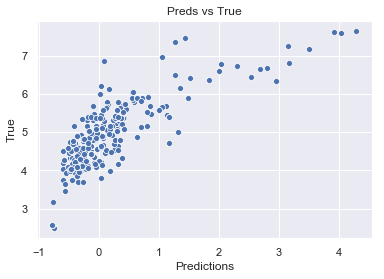

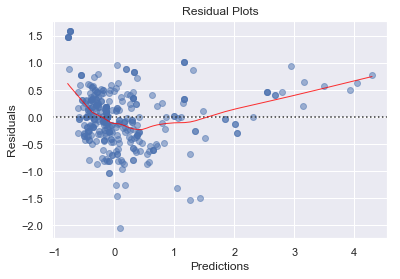

In [13]:
y_pred = results.predict(X_test_scale)
analyze_preds_true(y_pred, list(y_test))
# y_pred = results.predict(X_train_scale)
# analyze_preds_true(y_pred, list(y_train_all))

### regression with sqrt(N)

In [126]:
crime_data['sqrt_N'] = np.sqrt(crime_data.N)
X_train_all, y_train_all, X_train2016, y_train2016, X_test, y_test = create_train_test(crime_data,
                                                                                       cols=x_cols,
                                                                                       test_year=2017,
                                                                                       y_col='sqrt_N')

There are 1562 training obs and 347 test obs


In [127]:
X_scaler = StandardScaler()
X_scaler.fit(X_train_all)
X_train_scale = X_scaler.transform(X_train_all)
X_train_scale = pd.DataFrame(X_train_scale, columns=X_train_all.columns)
X_test_scale = X_scaler.transform(X_test)
X_test_scale = pd.DataFrame(X_test_scale, columns=X_test.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [128]:
model = sm.OLS(list(y_train_all), X_train_scale)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     36.26
Date:                Tue, 07 May 2019   Prob (F-statistic):           3.48e-64
Time:                        12:49:01   Log-Likelihood:                -6265.0
No. Observations:                1562   AIC:                         1.255e+04
Df Residuals:                    1552   BIC:                         1.260e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

Residual distribution:
 DescribeResult(nobs=347, minmax=(-32.352151129875594, -1.4409785954188639), mean=-11.665043751713618, variance=12.825547379270935, skewness=-0.8053270160228514, kurtosis=5.442304737586284)

MSE: 148.86183187702332


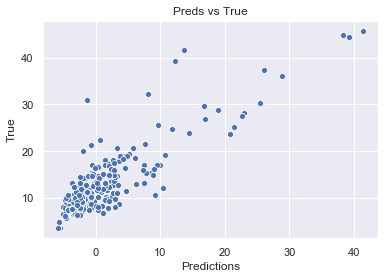

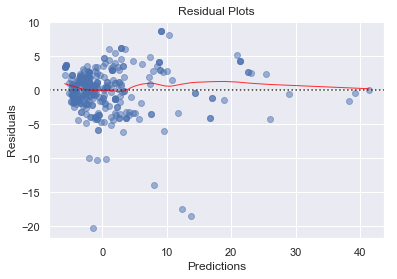

In [129]:
y_pred = results.predict(X_test_scale)
analyze_preds_true(y_pred, list(y_test))